In [1]:
import pandas as pd

In [2]:
db=pd.read_json('inspire_LA.json',dtype={'institution_id':int})

In [3]:
db.shape

(57588, 11)

In [4]:
from inspirehep import *

In [5]:
LA_countries=['Brazil', 'Mexico', 'Argentina','Chile', 'Colombia','Bolivia','Cuba', #5
              'Costa Rica', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras', #10
               'Nicaragua', 'Panama', 'Paraguay', 'Peru', #15
              'Dominican Republic','Uruguay','Venezuela']

In [6]:
db=db[db.country.apply(lambda s: s in LA_countries)].reset_index(drop=True)

In [7]:
db=db.drop_duplicates(subset=['institution_id']).reset_index(drop=True)

In [8]:
db.shape

(510, 11)

In [9]:
db.columns

Index(['author_id', 'country', 'email_addresses', 'full_name', 'ids',
       'institution', 'institution_id', 'name', 'papers', 'positions',
       'profile_id'],
      dtype='object')

In [10]:
import json

In [11]:
ld=json.loads(
    db[['country','institution','institution_id']].to_json(None, orient='records')
  )

In [12]:
from IPython.display import JSON

In [17]:
d={}
for x in ld:
    d[x.get('institution_id')]={'country':x.get('country'),'institution':x.get('institution')}

In [28]:
LA_institutions=db.institution_id.to_list()

In [ ]:
class experiments(profile):
    '''
    Query experiments API, default empty for all of them.
    For each experiment load the profile page of each author
    If the author is in the input list of institutions add to the database,
    icluding the input information for ['country','institution','institution_id'].
    
    Redefine 'papers' list to  dictionary with the colaboration information. 
    Redefine 'arXiv categories' with the collaboration name
    '''
    sleep=0.4    
    def __init__(self,q,institutions_db,db=[],not_collaboration=False,size=25,authors_size=25):
        self.q_inst=q
        self.db=db
        self.ld=institutions_db
        self.inst_ids=[ x.get('institution_id') for x in self.ld]
        self.size_exps=size
        self.authors_size=authors_size
        self.not_collaboration=not_collaboration
    def get_institutions(self):
        pass
    def get_authors(self):
        #get institutions from LA COUNTRY→ (institution_id, institution, country) if country==COUNTRY
        #d=get_institutions(self)
        #First while here
        #try:
        if not q:
            print('va 1')
            r=requests.get(f'https://inspirehep.net/api/experiments?size={self.size_exps}')
            self.r=r
        else:
            print('va 2')                
            r=requests.get(f'https://inspirehep.net/api/experiments?q={q}size={self.size_exps}')
        time.sleep(self.sleep)
        #except:
        #    print('va3')
        #    r=empty_json()
        print(r.status_code)
        if r.status_code!=200:
            self.db=db
            raise Exception('Failed JSON')
            
        lex=r.json().get('hits').get('hits')
        #While in lex
        ex=lex[0]
        ex_id=ex.get('id')
        #Get Experiment authors profiles
        #...
        # Get Experiment papers

In [199]:
if LEGACY:
        #collect collaboration but only store if LA country
        try:
            inst_insid=set([ x.get('record').get('$ref').split('/')[-1] 
               for x in p.get('metadata').get('positions') 
                 if x.get('current')]).intersection(self.inst_ids)
        except:
            inst_insid=set()
        #Fill institute information
        if not inst_insid:
            #continue
            pass
        
        ldi=[x for x in ld if x.get('institution_id')==list(inst_insid)[0]]
        if len(ldi)>0:
            ldi=ldi[0]
        else:
            #continue
            pass
        self.institution_id=ldi.get('institution_id')
        self.institution=ldi.get('institution')
        self.country=ldi.get('country')
        super(experiments, self).__init__(p.get('metadata'))             
        d=super(experiments, self).get_author() #→ self.profile
        #Fill author information
        #break
    def to_json(self):
        return [d.to_dict() for d in self.db]

In [19]:
r=requests.get(f'https://inspirehep.net/api/experiments?size={240}')

In [89]:
i=8
lex=r.json().get('hits').get('hits')
ex_id=lex[i].get('id')
ex_id

'1108783'

In [78]:
lex[i].get('metadata').get('normalized_name_variants')[0]#.get('value')

'SERP-E-177'

In [79]:
lex[i].get('metadata').get('inspire_classification')

In [80]:
lex[i].get('metadata').get('description')

'Approved for 360 hours. QUARTZ is a crystal diffraction spectrometer for hadronic X-rays with a semiconductor detector. Waiting for the run time (July 96).'

In [81]:
(lex[i].get('metadata').get('date_started'),
 lex[i].get('metadata').get('date_completed'))

(None, None)

In [101]:
f'https://inspirehep.net/api/authors?sort=bestmatch&size={ex_au_size}&page={ex_au_page}&q=project_membership.record.%24ref%3A{ex_id}'

'https://inspirehep.net/api/authors?sort=bestmatch&size=250&page=1&q=project_membership.record.%24ref%3A1108783'

In [114]:
ex_id=1108642
ex_au_size=250
ex_au_page=1
url=f'https://inspirehep.net/api/authors?sort=bestmatch&size={ex_au_size}&page={ex_au_page}&q=project_membership.record.%24ref%3A{ex_id}'
ex_au=requests.get(url)
#(f'https://inspirehep.net/api/authors?sort=bestmatch&size={ex_au_size}&page={ex_au_page}&q=project_membership.record.%24ref%3A{ex_id}')

In [98]:
JSON(r.json())#.get('hits').get('hits')

<IPython.core.display.JSON object>

In [116]:
j=0
lp=ex_au.json().get('hits').get('hits')[j].get('links').get('json')
lp

'https://inspirehep.net/api/authors/1018372?format=json'

In [117]:
profile=requests.get(lp)

In [115]:
JSON(ex_au.json())

<IPython.core.display.JSON object>

In [120]:
#TODO → Add project_membership to profile object
JSON(profile.json())

<IPython.core.display.JSON object>

In [95]:
%load_ext autoreload
%autoreload 2

In [200]:
C=experiments('',ld,db=[],size=250)

In [201]:
C.get_authors()

va 1
200


In [203]:
C.institution

'CINVESTAV, IPN'

In [204]:
C.institution_id

'903002'

In [205]:
C.country

'Mexico'

In [202]:
C.profile

{'positions': [{'record': {'$ref': 'https://inspirehep.net/api/institutions/903002'},
   'current': True,
   'institution': 'CINVESTAV, IPN',
   'curated_relation': True}],
 'project_membership': [{'name': 'FNAL-E-0823',
   'record': {'$ref': 'https://inspirehep.net/api/experiments/1110315'},
   'current': False,
   'curated_relation': True}],
 'ids': [{'value': 'INSPIRE-00009793', 'schema': 'INSPIRE ID'},
  {'value': 'HEPNAMES-810363', 'schema': 'SPIRES'},
  {'value': 'G.A.GarciaGuerra.1', 'schema': 'INSPIRE BAI'}],
 'name': {'value': 'Garcia-Guerra, G.Alejandro',
  'preferred_name': 'G.Alejandro Garcia-Guerra'},
 'stub': False,
 '$schema': 'https://inspirehep.net/schemas/records/authors.json',
 'deleted': False,
 'control_number': 1055072,
 'legacy_version': '20161012085916.0',
 'arxiv_categories': ['hep-ex'],
 'legacy_creation_date': '2008-06-05'}

In [ ]:
C.sle

In [173]:
C.r.status_code

200

In [75]:
r=C.r

In [100]:
lex=r.json().get('hits').get('hits')
ex=lex[0]
ex_id=ex.get('id')
ex_id

'1109650'

In [101]:
ex_id=1110315

In [167]:
authors_size=250
rr=requests.get(
    f'https://inspirehep.net/api/authors?sort=bestmatch&size={authors_size}&page=1&q=project_membership.record.%24ref%3A{ex_id}')

In [146]:
p=rr.json().get('hits').get('hits')[37:38][0]

In [147]:
inst_ids=[ x.get('institution_id') for x in ld]

In [152]:
try:
    int_insid=set([ x.get('record').get('$ref').split('/')[-1] 
       for x in p.get('metadata').get('positions') 
         if x.get('current')]).intersection(inst_ids)
except:
    inst_insid=[]

In [192]:
list(int_insid)[0]

'903002'

In [149]:
if int_insid: print(1)

1


In [127]:
P=profile(p.get('metadata'))

In [129]:
P.get_author()

In [130]:
P.to_dict()

{'email_addresses': None,
 'ids': [{'value': 'INSPIRE-00009793', 'schema': 'INSPIRE ID'},
  {'value': 'HEPNAMES-810363', 'schema': 'SPIRES'},
  {'value': 'G.A.GarciaGuerra.1', 'schema': 'INSPIRE BAI'}],
 'name': {'value': 'Garcia-Guerra, G.Alejandro',
  'preferred_name': 'G.Alejandro Garcia-Guerra'},
 'positions': [{'record': {'$ref': 'https://inspirehep.net/api/institutions/903002'},
   'current': True,
   'institution': 'CINVESTAV, IPN',
   'curated_relation': True}]}

In [96]:
rr=requests.get(exl)

In [97]:
rr.json()

{'links': {'json': 'https://inspirehep.net/api/experiments/1109650?format=json'},
 'updated': '2022-01-28T11:24:24.167672+00:00',
 'metadata': {'number_of_papers': 9,
  'core': True,
  'self': {'$ref': 'https://inspirehep.net/api/experiments/1109650'},
  '$schema': 'https://inspirehep.net/schemas/records/experiments.json',
  'long_name': '$\\pi p$ Elastic Scattering at Large Angles',
  'accelerator': {'value': 'FNAL-MR'},
  'description': 'Ran for 1550 hours.',
  'legacy_name': 'FNAL-E-0577',
  'institutions': [{'value': 'Fermilab',
    'record': {'$ref': 'https://inspirehep.net/api/institutions/902796'},
    'curated_relation': True}],
  'project_type': ['experiment'],
  'date_approved': '1978-06-29',
  'date_proposed': '1978-01-13',
  'control_number': 1109650,
  'date_completed': '1981-03-16',
  'legacy_version': '20180412224904.0',
  'legacy_creation_date': '2012-04-13',
  'inspire_classification': ['Fixed Target Experiments|Deep inelastic scattering'],
  'external_system_identifie

In [124]:
dp=pd.DataFrame( db.papers.apply(pd.Series).stack().to_list() ).drop_duplicates(subset='recid').reset_index(drop=True)

In [125]:
dp.shape

(49181, 7)

In [8]:
dp.citation_count.sum()

778399

In [28]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [114]:
dp['year']=dp['year'].apply(lambda y: eval(y) 
          ).fillna(0).astype(int)

<AxesSubplot:>

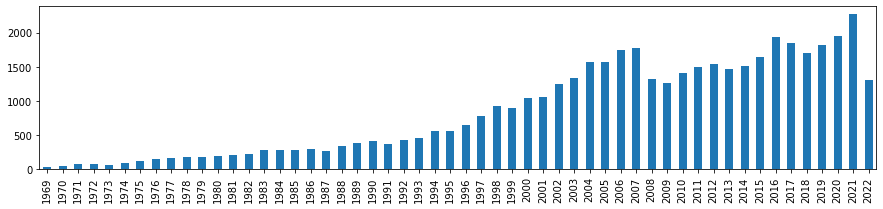

In [115]:
plt.figure(figsize=(15,3))
min_year=1968
dp[dp['year']>min_year][dp[dp['year']>min_year]['year']!='None'
                       ]['year'].value_counts().sort_index().plot(kind='bar')

In [116]:
instituion=db[db['institution'].str.contains('^Sao Paulo U.$')].iloc[0].get('institution_id')

<AxesSubplot:>

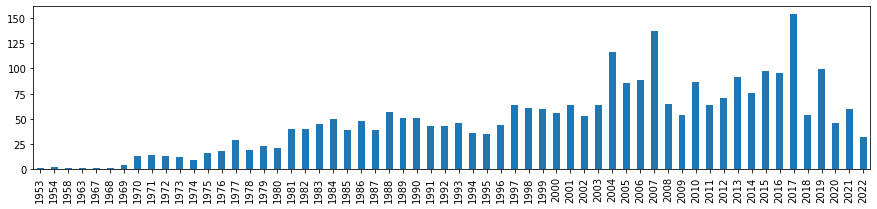

In [117]:
dpp=dp[dp['year']>1950]
plt.figure(figsize=(15,3))
dpp[dpp['instituion_id']==instituion]['year'].value_counts().sort_index().plot(kind='bar')

In [118]:
dp[dp['instituion_id']==instituion].shape

(3135, 7)

<AxesSubplot:>

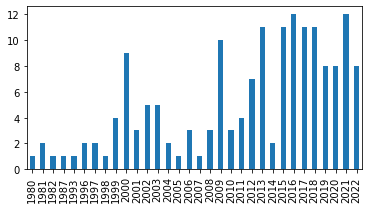

In [119]:
instituion=db[db['institution'].str.contains('^Antioquia U.$')].iloc[0].get('institution_id')
dpp=dp[dp['year']>1950]
plt.figure(figsize=(6,3))
dpp[dpp['instituion_id']==instituion]['year'].value_counts().sort_index().plot(kind='bar')

In [120]:
dpp[dpp['instituion_id']==instituion].shape

(165, 7)

In [122]:
dp[dp['instituion_id']==instituion].shape

(169, 7)